In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

### Logistic regression to classify salaries about a threshold
In our linear regression analysis, we find that there is a weak relationship between average salary and our predictor X variables. Thus, to reduce modeling difficulty, we attempt to classify salaries based on a certain threshold. From the EDA, we find that the median average salary is 97,000 USD, so we choose 100,000 as a reasonable classification threshold.

### Process data
We need to create dummy variables and delete unwanted columns. We also normalize the quantitative variables.

In [2]:
# read data
df = pd.read_csv('data/data_clean.csv')
df.head()

,avg_salary_k,rating,size,job_location,age,python,visual_software,ML_software,spark,aws,excel,sql,sas,hadoop,degree,in_CA,senior_status
0,72.0,3.8,501 - 1000,NM,48,1,1,0,0,0,1,0,1,0,MS,False,False
1,87.5,3.4,10000+,MD,37,1,0,0,0,0,0,0,0,0,MS,False,False
2,85.0,4.8,501 - 1000,FL,11,1,0,0,1,0,1,1,1,0,MS,False,False
3,76.5,3.8,1001 - 5000,WA,56,1,0,0,0,0,0,0,0,0,Other,False,False
4,114.5,2.9,51 - 200,NY,23,1,0,0,0,0,1,1,1,0,Other,False,False


In [3]:
# Create dummy variables for average salary
df['above_100k'] = df['avg_salary_k'] >= 100
df['above_100k'] = df['above_100k'].astype('int')
# Create dummy variables for degree
df['degree_other'] = pd.get_dummies(df['degree'])['Other']
df['degree_phd'] = pd.get_dummies(df['degree'])['PHD']
# Create dummy for inCA
df['in_CA'] = df['in_CA'].astype('int')
# Create dummy for senior_status
df['senior_status'] = df['senior_status'].astype('int')

In [4]:
# drop unneeded columns
df = df.drop(columns=['avg_salary_k', 'job_location', 'size', 'degree'])


In [5]:
# check work
df.head()

,rating,age,python,visual_software,ML_software,spark,aws,excel,sql,sas,hadoop,in_CA,senior_status,above_100k,degree_other,degree_phd
0,3.8,48,1,1,0,0,0,1,0,1,0,0,0,0,0,0
1,3.4,37,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.8,11,1,0,0,1,0,1,1,1,0,0,0,0,0,0
3,3.8,56,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2.9,23,1,0,0,0,0,1,1,1,0,0,0,1,1,0


In [6]:
# normalize quantitative features
df['rating'] = (df['rating'] - df['rating'].mean()) / df['rating'].std()
df['age'] = (df['age'] - df['age'].mean()) / df['age'].std()

In [7]:
# final check
df.head()

,rating,age,python,visual_software,ML_software,spark,aws,excel,sql,sas,hadoop,in_CA,senior_status,above_100k,degree_other,degree_phd
0,0.118576,-0.023746,1,1,0,0,0,1,0,1,0,0,0,0,0,0
1,-0.594528,-0.232038,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.901337,-0.724363,1,0,0,1,0,1,1,1,0,0,0,0,0,0
3,0.118576,0.127739,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,-1.485909,-0.497136,1,0,0,0,0,1,1,1,0,0,0,1,1,0


### Model validation using k-fold cross validation
We validate the model on out-of-sample testing using k-fold cross validation (k=10)

In [8]:
X = df.loc[:, df.columns != 'above_100k']
y = df['above_100k']

In [9]:
kf = KFold(n_splits=10) #create k-fold split indices
test_score = []
train_score = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # train model on X train and track accuracy on training data
    model = LogisticRegression()
    model.fit(X_train, y_train)
    train_score.append(model.score(X_train, y_train))

    # track accuracy on validation data
    predictions = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(predictions, y_test).ravel()
    test_accuracy = (tp+tn) / (tp+tn+fp+fn)
    test_score.append(test_accuracy)

# compare means
sum(train_score)/len(train_score), sum(test_score)/len(test_score)

(0.7344110473930525, 0.7022727272727274)

Here we find that the average test accuracy and train accuracy are reasonably close, which indicates that there is no severe overfitting. 
The accuracies are also decently high. Also note that the dataset is balanced since we classified salaries on approximately the median.

### Fit final model on all data

In [35]:
model_final = LogisticRegression()
model_final.fit(X, y)

# confusion matrix
predictions = model.predict(X)
tn, fp, fn, tp = confusion_matrix(predictions, y).ravel()
# final accuracy
model_final.score(X, y)

# coefficients
intercept = model.intercept_
coefficients = model.coef_
coeff_all = np.concatenate((intercept, coefficients[0]))

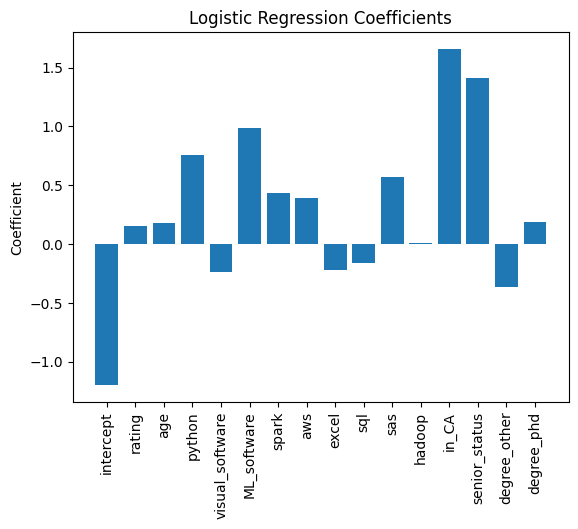

In [52]:
x_labels = X.columns.values
x_labels = np.concatenate((np.array(['intercept']), x_labels))

fig, ax = plt.subplots()
ax.bar(x=np.arange(len(coeff_all)), height=coeff_all)
ax.set_xticks(np.arange(len(x_labels)), labels=x_labels, rotation=90)
ax.set_title('Logistic Regression Coefficients')
ax.set_ylabel('Coefficient')
plt.savefig('figures/logistic_regression_coeffs.png', dpi=300)
